In [70]:
import healpy as hp
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline 
# Import the NaMaster python wrapper
import pymaster as nmt
import utils
from utils import smooth as smooth
from utils import deconv as deconv

# Functions

In [24]:
ali_ma = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits')

def Mask_0(maps):
    
    index0 = np.arange(len(ali_ma));
    mask_index0 = index0[np.where(ali_ma<1)]
    
    _ndim = len(maps.shape)
    if _ndim > 2:  ### (Nf, 3, npix)
        for i in range(maps.shape[0]):
            for j in range(3):
                maps[i,j][mask_index0] = 0
    elif _ndim == 2: ### (3, npix)
        for j in range(maps.shape[0]):
            maps[j][mask_index0] = 0
    
    else: ### (npix)
        maps[mask_index0] = 0
    return maps

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Test for usage of Namaster in ILC method

In [3]:
cmb_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(60), field = None)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


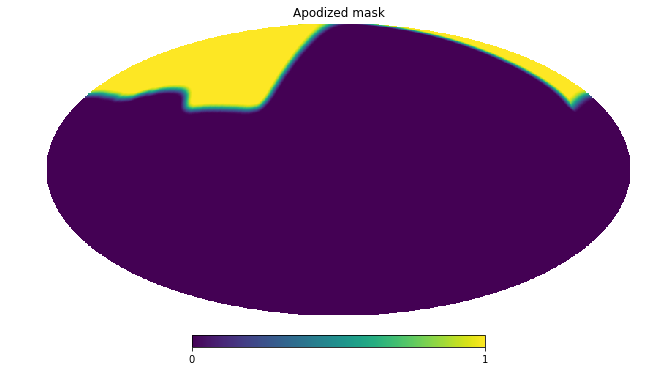

In [4]:
ali_ma = hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits", verbose=False)
mask = nmt.mask_apodization(ali_ma,  6, apotype='C2')
hp.mollview(mask, title='Apodized mask')

In [22]:
nside = 1024
b = nmt.NmtBin(nside, nlb=10, lmax=2000);

In [25]:
b_no_e = nmt.NmtField(mask, cmb_i[1:], purify_e=False, purify_b=True)  #, beam=bl) 

b_patch = nmt.NmtField(mask, Mask_0(cmb_i[1:]), purify_e=False, purify_b=True)  #, beam=bl) 

    
cl_i = nmt.compute_full_master(b_no_e, b_no_e,b) 

cl_i_patch = nmt.compute_full_master(b_patch, b_patch, b) 

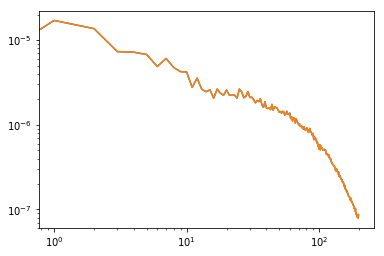

In [32]:
mode = 3
plt.loglog(cl_i[mode])
plt.loglog(cl_i_patch[mode])

## test for Power_spectrum for Namaster

- Define the **apodized mask**, **beam weights**, **nside**, **bin-scheme**, **ell**

In [167]:
beam_low = 27.9435; nside = 512; lmax = 1000

b = nmt.NmtBin(nside, nlb=10, lmax=lmax); ell_n = b.get_effective_ells(); eln2 = utils.l2(ell_n)

bl = hp.gauss_beam(beam_low/60/180*np.pi, lmax = 3*nside)

ali_ma_512 = hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits", verbose=False)
mask = nmt.mask_apodization(ali_ma_512,  6, apotype='C2')

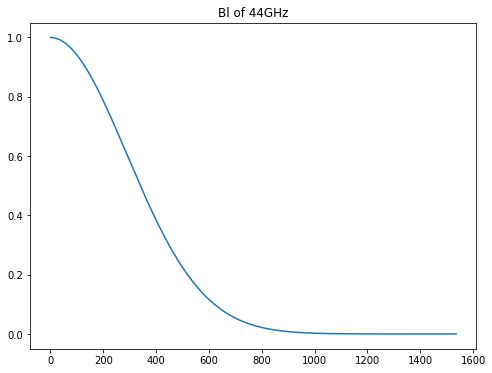

In [208]:
plt.figure(figsize = (8, 6 ))
plt.title('Bl of 44GHz')
plt.plot(bl)

In [169]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

- To construct a empty template with a mask to calculate the **coupling matrix**

> the template should have a shape (2, 12*nside^2)

In [210]:
map0 = np.ones((2, 12*nside**2))
m0 = nmt.NmtField(mask, map0, purify_e=False, purify_b=True)  ##, beam=bl

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(m0, m0, b)

In [212]:
def Cross_PS(maps):
    
    '''
    Calculate the E- and B-mode power spectrum utilize Namaster purify_B method.
    
    Given parameters:
    ----------------
    ell_n : the effective number of l_bins
    mask : apodized mask 
    beam : the gaussian beam weights for each multipole
        
    '''
    
    n_f = len(maps); lbin = len(ell_n)
    cl = np.ones((2, n_f*n_f, lbin)); Cl = np.zeros((2, lbin, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                
                m_i = nmt.NmtField(mask, maps[i][1:], purify_e=False, purify_b=True)#beam=bl); #Q and U maps at i-th fre
                m_j = nmt.NmtField(mask, maps[j][1:], purify_e=False, purify_b=True)#beam=bl); #Q and U maps at j-th fre
                
                cross_ps = compute_master(m_i, m_j, w) ## EE, EB, BE, BB
            else:
                cross_ps = np.zeros((4, len(ell_n))) 
                
            cl[0][k] = cross_ps[0]; cl[1][k] = cross_ps[3]  ## assign the E and B_mode power spectrum 
            k += 1
            
    for l in range(lbin):
        Cl[0, l, : , :] = cl[0, :,l].reshape(n_f, n_f); Cl[1, l, : , :] = cl[1, :,l].reshape(n_f, n_f)
        Cl[0, l] += Cl[0, l].T - np.diag(Cl[0, l].diagonal()) ; Cl[1, l] += Cl[1, l].T - np.diag(Cl[1, l].diagonal()) 
    return Cl

## To get the pseudo-Cl of the maps

In [68]:
# 13.0765 arcmin, K_CMB
fore70 = hp.ud_grade(hp.read_map('/fnx/jianyao/LFI_070/group2_map_detector_F070.fits', field = None, verbose = False), nside_out = 512)*1e6

#27.9435 arcmin, K_CMB
fore44 = hp.ud_grade(hp.read_map('/fnx/jianyao/LFI_044/group2_map_detector_F044.fits', field = None, verbose = False), nside_out = 512)*1e6

### 19 arcmin, uK_CMB
fore95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits', field = None, verbose = False), nside_out=512)  
### 11 arcmin, uK_CMB
fore150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits', field = None, verbose = False), nside_out=512) 
 ###4.944 arcmin, K_CMB
fore353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits', field = None, verbose = False), nside_out=512)*1e6

In [215]:
SamNum =100; beam_low = 27.9435; Nf = 5; nside = 512; lmax = 1000

## should use namaster instead; 2020-03-20 

for i in range(SamNum - 50):
#     if i < 50:
#         noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#         noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#     else: 
#         noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#         noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    
#     # K_CMB, nside = 1024, IQU
# #     noise_70 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/70GHz_LFI/70GHz_LFI_noise_070_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
#     noise_44 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/44GHz_LFI/noise_044_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
# #     noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    
#     Noise = np.zeros((Nf,3,12*nside**2))
#     Noise[0] = noise_44;
# #     Noise[1] = deconv(noise_70, beam_in = 13.0765, beam_out = beam_low, lmax = lmax + 100);
#     Noise[1] = deconv(noise_95, beam_in = 19, beam_out = beam_low, lmax = lmax + 100);  
#     Noise[2] = deconv(noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100); 
# #     Noise[3] = 0 # deconv(noise_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100);
#     noise_ps_i = utils.Power_spectrum(Mask(Noise), 0, lmax = lmax);
#     np.save('/fnx/jianyao/ancillary_data/3_fre_44_with_noise/noise_ps/nl_deconv_masked_EB_%s.npy'%i, noise_ps_i)
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(i), field = None, verbose = False), nside_out = 512)
    
    total = np.zeros((Nf, 3, 12*nside**2))
    total[0] = smooth(cmb_i, beam_out = beam_low, lmax = lmax + 100) + fore44 #+ noise_44 
    total[1] = deconv(smooth(cmb_i, beam_out = 13.0765, lmax = lmax + 100) + fore70 , beam_in = 13.0765, beam_out = beam_low, lmax = lmax + 100) #+ noise_70
    total[2] = deconv(smooth(cmb_i, beam_out = 19, lmax = lmax + 100) + fore95 , beam_in = 19, beam_out = beam_low, lmax = lmax + 100) #+ noise_95
    total[3] = deconv(smooth(cmb_i, beam_out=11, lmax = lmax + 100) + fore150 , beam_in = 11, beam_out = beam_low, lmax = lmax + 100) #+ noise_150
    total[4] = deconv(smooth(cmb_i, beam_out=4.944, lmax = lmax + 100) + fore353 , beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) #+ noise_353
        
    total_ps_i = Cross_PS(total)
    np.save('/fnx/jianyao/ancillary_data/5_fre_namaster_no_noise_beamed/total_ps/total_ps_deconv_masked_EB_%s.npy'%i, total_ps_i)

In [214]:
total_ps_i.shape

(2, 99, 5, 5)

## ILC for Namaster

In [216]:
path = '/fnx/jianyao/ancillary_data/5_fre_namaster_no_noise_beamed/'
# noise_ps_mean = np.zeros((2, lmax+1, Nf, Nf))

# for n in range(SamNum):
#     noise_ps_mean += np.load('%s/noise_ps/nl_deconv_masked_EB_%s.npy'%(path, n))

# noise_ps_mean /= SamNum

In [224]:
cl_clean_44 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_mean_namaster_44_with_beam.npy')  ## B-mode only 

- 2020-03-24

> modify the taking part procedure, and add automatic way for ploting

> use defined **bin scheme**

In [256]:
total_ps_i[mode][25]

array([[2.19176658e-06, 1.36038076e-06, 1.19887173e-06, 1.14466983e-06,
        2.18270959e-06],
       [1.36038076e-06, 1.14135677e-06, 1.10155456e-06, 1.09633471e-06,
        1.68118402e-06],
       [1.19887173e-06, 1.10155456e-06, 1.08893093e-06, 1.10583842e-06,
        2.05573726e-06],
       [1.14466983e-06, 1.09633471e-06, 1.10583842e-06, 1.18021897e-06,
        4.08868375e-06],
       [2.18270959e-06, 1.68118402e-06, 2.05573726e-06, 4.08868375e-06,
        8.32553067e-05]])

In [248]:
SamNum = 100 - 50; Q = len(ell_n) #lmax + 1 
# lmax = 1000,意味着有1001个l,Q应该等于1001; 想要得到干净的天图的时候，
names = ['Q_polarization', 'U_polarization']

Nf = 3

Cl_ilc = np.zeros((SamNum, Q)); itera = 1; mode = 1; #Fore_cl= np.zeros((SamNum, Q)); sync_cl = np.zeros((SamNum, Q)); dust_cl = np.zeros((SamNum, Q))
for n in range(SamNum): 

    e = np.matrix(np.ones(Nf))
    total_ps_i = np.load('%s/total_ps/total_ps_deconv_masked_EB_%s.npy'%(path, n))
   
    ## Power_spectrum return EE and BB at the same time. So total_ps[0] = EE; total_ps[1] = BB
#     noise_bin = noise_ps_mean[mode]; #noise_ps_mean[mode]#
#     noise_ilc = np.zeros(Q); 
    total_bin_i = total_ps_i[mode]; #total_ps_i[mode]#
    
    # take some part of the cross power spectrum matrix
    total_bin = np.ones((Q, Nf,Nf)); sel = np.array((1,2,3))
    for q in range(Q):
        x = 0; 
        for i in (sel):
            y = 0;
            for j in (sel):
                
                total_bin[q][x,y] = total_bin_i[q][i, j]
                y += 1;
                
            x += 1;
            
#     fore_bin = utils.bin_l(fore_ps[mode], lmax, Q); sync_bin = utils.bin_l(sync_ps[mode], lmax, Q); dust_bin = utils.bin_l(dust_ps[mode], lmax, Q);

#     for r in range(itera):
#         if r == 0:
#             nuisance = noise_bin
            
#         else:
#             nuisance = total_bin - All_matrix(Cl_ilc[n], Nf)

    #calculate the weight
    W = np.matrix(np.zeros((Q, Nf)))

    for l in range(Q):
        norm = e*np.linalg.pinv((total_bin[l]))*e.T

        W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   

    for i in range(Q):

        ''' whether include noise_bin or not;  WNW = 1/(eN{-1}e.T)'''

#             noise_ilc[i] = W[i,:]*(nuisance[i])*np.transpose(W[i,:])     #noise_bin　nuisance[i]
        Cl_ilc[n, i] = W[i,:]*(total_bin[i])*np.transpose(W[i,:]) #- noise_ilc[i]  #1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) 


cl_ilc_mean = np.mean(Cl_ilc, axis = 0)
cl_ilc_std = np.std(Cl_ilc, axis = 0)

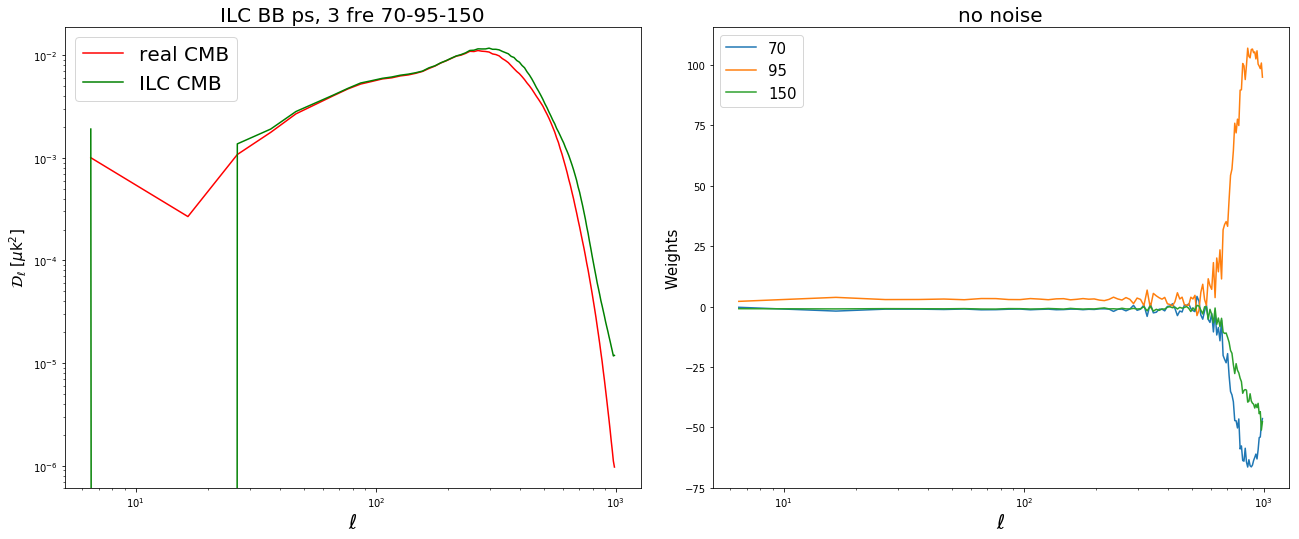

In [249]:
fig1 = plt.figure(1, figsize=(20,8)); psn = ['EE', 'BB']; fre = ['44', '70','95','150','353']
# plt.axis('off')
frame1=fig1.add_axes((.1,.1,.4,.8)) # x0, y0, width, height

plt.loglog(ell_n, eln2*cl_clean_44[mode], 'r-',label = 'real CMB')
plt.loglog(ell_n,eln2*(cl_ilc_mean), 'g-', label = 'ILC CMB')

# plt.errorbar(ell_n, eln2*cl_ilc_mean, yerr = eln2*cl_ilc_std,fmt='bo',capthick = 0.1)
# plt.ylim(1e-4, 1e-1)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
# plt.grid()
plt.title('ILC %s ps, %s fre 70-95-150'%(psn[mode], Nf), fontsize = 20)

frame2=fig1.add_axes((.55,.1,.4,.8))
for i in range(Nf):
    plt.plot(ell_n, W[:, i], label = '%s'%fre[sel[i]])
plt.xscale('log')
plt.legend(fontsize = 15)
plt.ylabel('Weights', fontsize = 15)
plt.xlabel('$\ell$', fontsize = 20); 
plt.title('no noise',fontsize = 20)

# 
plt.savefig('/home/jianyao/Ali_maps/results/0324_namater_no_noise/refined_mask_3_fre%s_70_beamed.jpg'%psn[mode], format = 'jpg')